In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from scipy.stats import wishart
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import KFold
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature
from matplotlib.patches import Circle


C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\1964532061.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color = 'grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\1964532061.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color = 'grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\1964532061.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color = 'grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\1964532061.py:

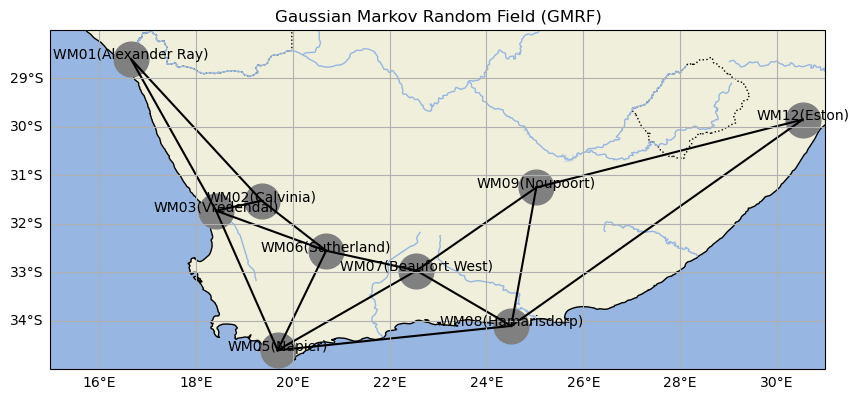

In [2]:
# Load the synthetic geological map
geo_map = gpd.read_file('synthetic_geological_map.shp')

# Define the DMS to Decimal Degrees conversion function
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Convert coordinates
wm01_lat = dms_to_dd(28, 36, 6.7, 'S')
wm01_lon = dms_to_dd(16, 39, 51.9, 'E')

wm02_lat = dms_to_dd(31, 31, 29.7, 'S')
wm02_lon = dms_to_dd(19, 21, 38.7, 'E')

wm03_lat = dms_to_dd(31, 43, 49.4, 'S')
wm03_lon = dms_to_dd(18, 25, 10.1, 'E')

wm05_lat = dms_to_dd(34, 36, 41.6, 'S')
wm05_lon = dms_to_dd(19, 41, 30.3, 'E')

wm06_lat = dms_to_dd(32, 33, 24.4, 'S')
wm06_lon = dms_to_dd(20, 41, 28.7, 'E')

wm07_lat = dms_to_dd(32, 58, 0.2, 'S')
wm07_lon = dms_to_dd(22, 33, 23.8, 'E')

wm08_lat = dms_to_dd(34, 6, 32.0, 'S')
wm08_lon = dms_to_dd(24, 30, 49.0, 'E')

wm09_lat = dms_to_dd(31, 15, 5.8, 'S')
wm09_lon = dms_to_dd(25, 1, 50.2, 'E')

wm12_lat = dms_to_dd(29, 51, 0.4, 'S')
wm12_lon = dms_to_dd(30, 31, 42.8, 'E')

# Update positions dictionary with decimal degrees
pos = {
    'WM01(Alexander Ray)': (wm01_lon, wm01_lat),
    'WM02(Calvinia)': (wm02_lon, wm02_lat),
    'WM03(Vredendal)': (wm03_lon, wm03_lat),
    'WM05(Napier)': (wm05_lon, wm05_lat),
    'WM06(Sutherland)': (wm06_lon, wm06_lat),
    'WM07(Beaufort West)': (wm07_lon, wm07_lat),
    'WM08(Hamarisdorp)': (wm08_lon, wm08_lat),
    'WM09(Noupoort)': (wm09_lon, wm09_lat),
    'WM12(Eston)': (wm12_lon, wm12_lat)
}

# Create a Gaussian Markov network
G = nx.Graph()
regions = list(pos.keys())
edges = [
    ('WM01(Alexander Ray)', 'WM02(Calvinia)'), ('WM01(Alexander Ray)', 'WM03(Vredendal)'), ('WM02(Calvinia)', 'WM03(Vredendal)'),
    ('WM02(Calvinia)', 'WM06(Sutherland)'), ('WM03(Vredendal)', 'WM06(Sutherland)'), ('WM03(Vredendal)', 'WM05(Napier)'),
    ('WM05(Napier)', 'WM06(Sutherland)'), ('WM05(Napier)', 'WM07(Beaufort West)'), ('WM07(Beaufort West)', 'WM06(Sutherland)'),
    ('WM07(Beaufort West)', 'WM08(Hamarisdorp)'), ('WM08(Hamarisdorp)', 'WM09(Noupoort)'), ('WM08(Hamarisdorp)', 'WM12(Eston)'),
    ('WM09(Noupoort)', 'WM12(Eston)'), ('WM07(Beaufort West)', 'WM09(Noupoort)'), ('WM08(Hamarisdorp)', 'WM05(Napier)')
]
G.add_nodes_from(regions)
G.add_edges_from(edges)

# Create a figure with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural earth features for better map visualization
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the geological map
geo_map.plot(ax=ax, color='white', edgecolor='black')

# Add nodes with positions
for node, (lon, lat) in pos.items():
    ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color = 'grey')
    ax.text(lon, lat, node, transform=ccrs.PlateCarree(), fontsize=10, ha='center', color='black')

# Add edges
for (region1, region2) in edges:
    lon1, lat1 = pos[region1]
    lon2, lat2 = pos[region2]
    ax.plot([lon1, lon2], [lat1, lat2], 'b-', transform=ccrs.PlateCarree(), color = 'black')

# Set the extent of the map
ax.set_extent([15, 31, -35, -28])

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.title("Gaussian Markov Random Field (GMRF)")
plt.show()


In [20]:
#importing the dataset and cleaning it 
data = pd.read_csv("wind_speedPdata 1.csv", delimiter=';')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.to_numpy()

cleaned_data = []
for row in data:
    cleaned_row = [float(x) if isinstance(x, str) and x.strip() else np.nan if isinstance(x, str) else x for x in row]
    cleaned_data.append(cleaned_row)

data_array = np.array(cleaned_data, dtype=np.float64)
X = data_array[:, :-1]

In [4]:
class GMRFModelBL(BaseEstimator, RegressorMixin):
    def __init__(self, diag_value=2, nu_prior=None):
        self.diag_value = diag_value
        self.nu_prior = nu_prior

        # Define the edges and node to index mapping
        self.edges = [
            ('WM01', 'WM02'), ('WM01', 'WM03'), ('WM02', 'WM03'),
            ('WM02', 'WM06'), ('WM03', 'WM06'), ('WM03', 'WM05'),
            ('WM05', 'WM06'), ('WM05', 'WM07'), ('WM07', 'WM06'),
            ('WM07', 'WM08'), ('WM08', 'WM09'), ('WM08', 'WM12'),
            ('WM09', 'WM12'), ('WM07', 'WM09'), ('WM08', 'WM05')
        ]
        self.node_to_index = {'WM01': 0, 'WM02': 1, 'WM03': 2, 'WM05': 3, 
                              'WM06': 4, 'WM07': 5, 'WM08': 6, 'WM09': 7, 'WM12': 8}

    def fit(self, X_train, y=None):
        self.n_features = X_train.shape[1]

        # Set default nu_prior if not provided
        if self.nu_prior is None:
            self.nu_prior = self.n_features

        # Compute the empirical mean vector and covariance matrix using the training set
        self.mu_empirical_train = np.mean(X_train, axis=0)
        Sigma_empirical_train = np.cov(X_train, rowvar=False)

        # Define prior and sample posterior precision matrix using the training set
        self.Lambda = np.zeros((self.n_features, self.n_features))
        np.fill_diagonal(self.Lambda, self.diag_value)

        # Update Lambda based on the defined edges
        for (node1, node2) in self.edges:
            idx1 = self.node_to_index[node1]
            idx2 = self.node_to_index[node2]
            self.Lambda[idx1, idx2] = -1
            self.Lambda[idx2, idx1] = -1

        Psi_prior = np.eye(self.n_features)
        nu_posterior = self.nu_prior + X_train.shape[0]
        Psi_posterior = Psi_prior + np.dot(X_train.T, X_train)

        # Sample the posterior precision matrix from the Wishart distribution
        self.Lambda_posterior = wishart.rvs(df=nu_posterior, scale=np.linalg.inv(Psi_posterior))

        # Define Lambda_posterior_chain1 based on the posterior
        self.Lambda_posterior_chain1 = np.zeros_like(self.Lambda_posterior)
        np.fill_diagonal(self.Lambda_posterior_chain1, np.diag(self.Lambda_posterior))
        for (node1, node2) in self.edges:
            idx1 = self.node_to_index[node1]
            idx2 = self.node_to_index[node2]
            self.Lambda_posterior_chain1[idx1, idx2] = self.Lambda_posterior[idx1, idx2]
            self.Lambda_posterior_chain1[idx2, idx1] = self.Lambda_posterior[idx2, idx1]

        return self

    def predict(self, X_test):
        # If indices are not provided, raise an error
        if self.observed_indices is None or self.unobserved_indices is None:
            raise ValueError("Observed and unobserved indices must be provided for prediction.")

        # Define the inference method
        def infer_unobserved_test(precision_matrix, mu, observed_indices, observed_values, unobserved_indices):
            Lambda_oo = precision_matrix[np.ix_(observed_indices, observed_indices)]
            Lambda_ou = precision_matrix[np.ix_(observed_indices, unobserved_indices)]
            Lambda_uu = precision_matrix[np.ix_(unobserved_indices, unobserved_indices)]

            mu_u_given_o = mu[unobserved_indices] - np.dot(
                np.linalg.inv(Lambda_uu), 
                np.dot(Lambda_ou.T, (observed_values - mu[observed_indices]))
            )
            return mu_u_given_o

        # Predict unobserved values for each test sample
        predicted_values_test_all = []
        for test_sample in X_test:
            observed_values_test = test_sample[self.observed_indices]
            predicted_values_test = infer_unobserved_test(
                self.Lambda_posterior_chain1, 
                self.mu_empirical_train, 
                self.observed_indices, 
                observed_values_test, 
                self.unobserved_indices
            )
            predicted_values_test_all.append(predicted_values_test)

        return np.array(predicted_values_test_all)


In [5]:


class GMRFModelEBE(BaseEstimator, RegressorMixin):
    def __init__(self, diag_value=2, prior_df=5, prior_scale=None, prior_mean=None, prior_cov=None, observed_indices=None, unobserved_indices=None):
        self.diag_value = diag_value
        self.prior_df = prior_df  # Degrees of freedom for Wishart distribution
        self.prior_scale = prior_scale  # Scale matrix for Wishart distribution
        self.prior_mean = prior_mean  # Mean vector for prior Normal distribution
        self.prior_cov = prior_cov  # Covariance matrix for prior Normal distribution
        self.observed_indices = observed_indices  
        self.unobserved_indices = unobserved_indices 

    def fit(self, X_train, y=None):
        self.n_features = X_train.shape[1]

        # Compute empirical mean vector and covariance matrix
        self.mu_empirical_train = np.mean(X_train, axis=0)
        Sigma_empirical_train = np.cov(X_train, rowvar=False)

        # Prior distributions
        if self.prior_scale is None:
            self.prior_scale = np.eye(self.n_features)  # Prior scale matrix (identity matrix)

        if self.prior_mean is None:
            self.prior_mean = np.zeros(self.n_features)  # Prior mean vector (zero vector)

        if self.prior_cov is None:
            self.prior_cov = np.eye(self.n_features)  # Prior covariance matrix (identity matrix)

        # Update the precision matrix (Lambda) and mean vector (mu) using Empirical Bayes Estimation
        Lambda_posterior = wishart.rvs(df=self.prior_df + X_train.shape[0],
                                       scale=np.linalg.inv(self.prior_scale + X_train.shape[0] * Sigma_empirical_train))

        mu_posterior_cov = np.linalg.inv(np.linalg.inv(self.prior_cov) + X_train.shape[0] * np.linalg.inv(Sigma_empirical_train))
        mu_posterior_mean = np.dot(mu_posterior_cov, np.dot(np.linalg.inv(self.prior_cov), self.prior_mean) +
                                   X_train.shape[0] * np.dot(np.linalg.inv(Sigma_empirical_train), self.mu_empirical_train))

        self.Lambda_ebe = Lambda_posterior
        self.mu_ebe = mu_posterior_mean

        # Define node to index mapping
        node_to_index = {'WM01': 0, 'WM02': 1, 'WM03': 2, 'WM05': 3, 'WM06': 4, 'WM07': 5, 'WM08': 6, 'WM09': 7, 'WM12': 8}
        
        # Define edges
        edges = [
            ('WM01', 'WM02'), ('WM01', 'WM03'), ('WM02', 'WM03'),
            ('WM02', 'WM06'), ('WM03', 'WM06'), ('WM03', 'WM05'),
            ('WM05', 'WM06'), ('WM05', 'WM07'), ('WM07', 'WM06'),
            ('WM07', 'WM08'), ('WM08', 'WM09'), ('WM08', 'WM12'),
            ('WM09', 'WM12'), ('WM07', 'WM09'), ('WM08', 'WM05')
        ]

        # Initialize the precision matrix
        self.Lambda = np.zeros((self.n_features, self.n_features))

        # Fill in the diagonal elements based on Lambda_ebe
        np.fill_diagonal(self.Lambda, np.diag(self.Lambda_ebe))

        # Add connections according to the edges list
        for edge in edges:
            i, j = node_to_index[edge[0]], node_to_index[edge[1]]
            self.Lambda[i, j] = self.Lambda_ebe[i, j]
            self.Lambda[j, i] = self.Lambda_ebe[j, i]

        return self

    def predict(self, X_test):
        # Use the class attributes for observed and unobserved indices
        observed_indices_test = self.observed_indices
        unobserved_indices_test = self.unobserved_indices

        def infer_unobserved_test(precision_matrix, mu, observed_indices, observed_values, unobserved_indices):
            Lambda_oo = precision_matrix[np.ix_(observed_indices, observed_indices)]
            Lambda_ou = precision_matrix[np.ix_(observed_indices, unobserved_indices)]
            Lambda_uu = precision_matrix[np.ix_(unobserved_indices, unobserved_indices)]

            mu_u_given_o = mu[unobserved_indices] - np.dot(np.linalg.inv(Lambda_uu), np.dot(Lambda_ou.T, (observed_values - mu[observed_indices])))
            return mu_u_given_o

        predicted_values_test_all = []
        for test_sample in X_test:
            observed_values_test = test_sample[observed_indices_test]
            predicted_values_test = infer_unobserved_test(self.Lambda, self.mu_ebe, observed_indices_test, observed_values_test, unobserved_indices_test)
            predicted_values_test_all.append(predicted_values_test)

        return np.array(predicted_values_test_all)


In [6]:
class GMRFModelMLE(BaseEstimator, RegressorMixin):
    def __init__(self, diag_value=2, observed_indices=None, unobserved_indices=None):
        self.diag_value = diag_value

        # Allow observed and unobserved indices to be passed in or set defaults
        self.observed_indices = observed_indices 
        self.unobserved_indices = unobserved_indices 

    def fit(self, X_train, y=None):
        self.n_features = X_train.shape[1]

        # Compute the empirical mean vector and covariance matrix using the training set
        self.mu_empirical_train = np.mean(X_train, axis=0)
        Sigma_empirical_train = np.cov(X_train, rowvar=False)

        # Define the precision matrix (Lambda) based on the empirical covariance matrix (MLE)
        self.Lambda_mle = np.linalg.inv(Sigma_empirical_train)

        # Initialize the precision matrix with zeros
        self.Lambda = np.zeros((self.n_features, self.n_features))

        # Set up the edges and map them to indices in the dataset
        edges = [
            ('WM01', 'WM02'), ('WM01', 'WM03'), ('WM02', 'WM03'),
            ('WM02', 'WM06'), ('WM03', 'WM06'), ('WM03', 'WM05'),
            ('WM05', 'WM06'), ('WM05', 'WM07'), ('WM07', 'WM06'),
            ('WM07', 'WM08'), ('WM08', 'WM09'), ('WM08', 'WM12'),
            ('WM09', 'WM12'), ('WM07', 'WM09'), ('WM08', 'WM05')
        ]

        # Map node names to column indices in X_train
        node_to_index = {'WM01': 0, 'WM02': 1, 'WM03': 2, 'WM05': 3, 'WM06': 4, 'WM07': 5,  'WM08': 6, 'WM09': 7, 'WM12': 8}

        # Fill in the precision matrix with values according to the specified edges
        for edge in edges:
            i, j = node_to_index[edge[0]], node_to_index[edge[1]]
            self.Lambda[i, j] = self.Lambda_mle[i, j]
            self.Lambda[j, i] = self.Lambda_mle[j, i]

        # Add diagonal values from MLE
        np.fill_diagonal(self.Lambda, np.diag(self.Lambda_mle) + self.diag_value)
        return self

    def predict(self, X_test):
        # Use the class attributes for observed and unobserved indices
        observed_indices_test = self.observed_indices
        unobserved_indices_test = self.unobserved_indices

        def infer_unobserved_test(precision_matrix, mu, observed_indices, observed_values, unobserved_indices):
            Lambda_oo = precision_matrix[np.ix_(observed_indices, observed_indices)]
            Lambda_ou = precision_matrix[np.ix_(observed_indices, unobserved_indices)]
            Lambda_uu = precision_matrix[np.ix_(unobserved_indices, unobserved_indices)]

            mu_u_given_o = mu[unobserved_indices] - np.dot(np.linalg.inv(Lambda_uu), np.dot(Lambda_ou.T, (observed_values - mu[observed_indices])))
            return mu_u_given_o

        predicted_values_test_all = []
        for test_sample in X_test:
            observed_values_test = test_sample[observed_indices_test]
            predicted_values_test = infer_unobserved_test(self.Lambda, self.mu_empirical_train, observed_indices_test, observed_values_test, unobserved_indices_test)
            predicted_values_test_all.append(predicted_values_test)

        return np.array(predicted_values_test_all)


In [7]:
class GMRFModel(BaseEstimator, RegressorMixin):
    def __init__(self, diag_value=2, n_edges=15, prior_mean=None, prior_scale=None, prior_df=1, observed_indices=None, unobserved_indices=None):
        self.diag_value = diag_value
        self.n_edges = n_edges
        self.observed_indices = observed_indices  
        self.unobserved_indices = unobserved_indices 
        self.prior_mean = prior_mean  # Prior mean for the parameters
        self.prior_scale = prior_scale  # Prior scale matrix for the precision
        self.prior_df = prior_df  # Degrees of freedom for the Wishart distribution

    def fit(self, X_train, y=None):
        self.n_features = X_train.shape[1]

        # Compute empirical mean vector and covariance matrix
        self.mu_empirical_train = np.mean(X_train, axis=0)
        Sigma_empirical_train = np.cov(X_train, rowvar=False)

        # Set prior distributions
        if self.prior_scale is None:
            self.prior_scale = np.eye(self.n_features)  # Default to identity matrix if not specified

        if self.prior_mean is None:
            self.prior_mean = np.zeros(self.n_features)  # Default to zero vector if not specified

        # Bayesian learning for the precision matrix (Lambda)
        Lambda_posterior = wishart.rvs(df=self.prior_df + X_train.shape[0],
                                       scale=np.linalg.inv(self.prior_scale + X_train.shape[0] * Sigma_empirical_train))

        # Bayesian learning for the posterior mean (mu)
        mu_posterior_cov = np.linalg.inv(np.linalg.inv(self.prior_scale) + X_train.shape[0] * np.linalg.inv(Sigma_empirical_train))
        mu_posterior_mean = np.dot(mu_posterior_cov, np.dot(np.linalg.inv(self.prior_scale), self.prior_mean) +
                                   X_train.shape[0] * np.dot(np.linalg.inv(Sigma_empirical_train), self.mu_empirical_train))

        self.Lambda = Lambda_posterior
        self.mu = mu_posterior_mean

        # Initialize the precision matrix with zeros
        self.Lambda_graph = np.zeros((self.n_features, self.n_features))
        np.fill_diagonal(self.Lambda_graph, self.diag_value)

        # Create a fully connected minimum spanning tree
        mst_graph = nx.minimum_spanning_tree(nx.complete_graph(self.n_features))
        graph = nx.Graph(mst_graph)  # Start with MST edges

        # Add random edges until reaching the target number of edges
        possible_edges = list(nx.complete_graph(self.n_features).edges)
        np.random.shuffle(possible_edges)

        for edge in possible_edges:
            if len(graph.edges) >= self.n_edges:
                break
            if not graph.has_edge(*edge):
                graph.add_edge(*edge)

        # Set precision matrix values based on edges in the fully connected graph
        for i, j in graph.edges:
            self.Lambda_graph[i, j] = self.Lambda[i, j]
            self.Lambda_graph[j, i] = self.Lambda[j, i]

        return self

    def predict(self, X_test):
        if self.observed_indices is None or self.unobserved_indices is None:
            raise ValueError("Observed and unobserved indices must be provided for prediction.")

        def infer_unobserved_test(precision_matrix, mu, observed_indices, observed_values, unobserved_indices):
            Lambda_oo = precision_matrix[np.ix_(observed_indices, observed_indices)]
            Lambda_ou = precision_matrix[np.ix_(observed_indices, unobserved_indices)]
            Lambda_uu = precision_matrix[np.ix_(unobserved_indices, unobserved_indices)]

            mu_u_given_o = mu[unobserved_indices] - np.dot(
                np.linalg.inv(Lambda_uu),
                np.dot(Lambda_ou.T, (observed_values - mu[observed_indices]))
            )
            return mu_u_given_o

        predicted_values_test_all = []
        for test_sample in X_test:
            observed_values_test = test_sample[self.observed_indices]
            predicted_values_test = infer_unobserved_test(
                self.Lambda_graph, self.mu, 
                self.observed_indices, observed_values_test, 
                self.unobserved_indices
            )
            predicted_values_test_all.append(predicted_values_test)

        return np.array(predicted_values_test_all)


## Ploting the averaged learning curves for each GMRF model with error bars

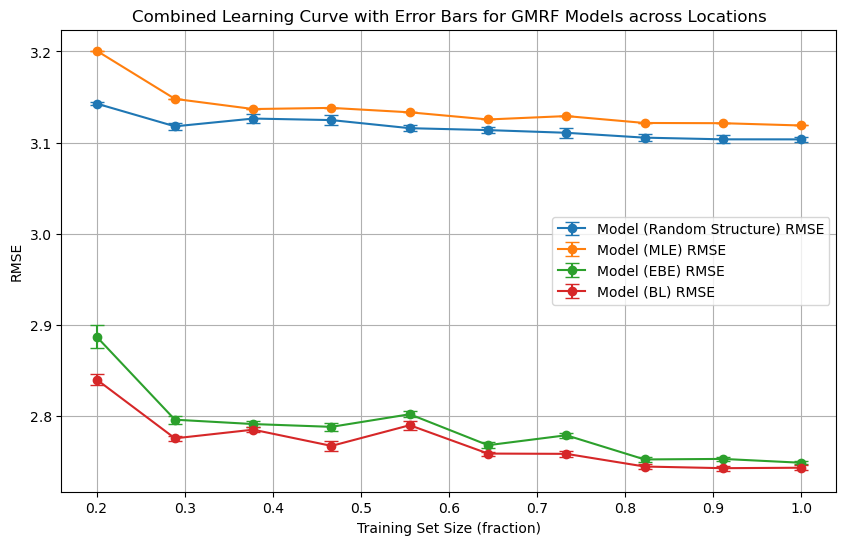

In [12]:
def plot_combined_learning_curve_with_error_bars(X1, X2, X3, y1, y2, y3, models, 
                                                 observed_indices1, unobserved_indices1, 
                                                 observed_indices2, unobserved_indices2,
                                                 observed_indices3, unobserved_indices3,
                                                 increments=10, k_folds=5, repeats=10):
    # Store RMSE values for each model, train size, and repeat
    all_rmse_scores = {model_name: {train_size: [] for train_size in np.linspace(0.2, 1.0, increments)}
                       for model_name in models.keys()}

    train_sizes = np.linspace(0.2, 1.0, increments)

    # Repeat the process multiple times to calculate mean and standard deviation
    for _ in range(repeats):
        for train_size in train_sizes:
            # Initialize lists to collect RMSE values for each model across locations
            rmse_scores_location1 = {model_name: [] for model_name in models.keys()}
            rmse_scores_location2 = {model_name: [] for model_name in models.keys()}
            rmse_scores_location3 = {model_name: [] for model_name in models.keys()}

            # K-fold cross-validation setup
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

            # Compute RMSE for location 1
            for train_index, test_index in kf.split(X1):
                X_train_full, X_test = X1[train_index], X1[test_index]
                y_train_full, y_test = y1[train_index], y1[test_index]

                # Reduce the training set according to train_size
                train_size_idx = int(len(X_train_full) * train_size)
                X_train = X_train_full[:train_size_idx]
                y_train = y_train_full[:train_size_idx]

                for model_name, model in models.items():
                    # Set observed/unobserved indices for location 1
                    model.observed_indices = observed_indices1
                    model.unobserved_indices = unobserved_indices1
                    model.fit(X_train)
                    predictions = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, predictions))
                    rmse_scores_location1[model_name].append(rmse)

            # Compute RMSE for location 2
            for train_index, test_index in kf.split(X2):
                X_train_full, X_test = X2[train_index], X2[test_index]
                y_train_full, y_test = y2[train_index], y2[test_index]

                # Reduce the training set according to train_size
                train_size_idx = int(len(X_train_full) * train_size)
                X_train = X_train_full[:train_size_idx]
                y_train = y_train_full[:train_size_idx]

                for model_name, model in models.items():
                    # Set observed/unobserved indices for location 3
                    model.observed_indices = observed_indices2
                    model.unobserved_indices = unobserved_indices2
                    model.fit(X_train)
                    predictions = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, predictions))
                    rmse_scores_location2[model_name].append(rmse)

            # Compute RMSE for location 3
            for train_index, test_index in kf.split(X3):
                X_train_full, X_test = X3[train_index], X3[test_index]
                y_train_full, y_test = y3[train_index], y3[test_index]

                # Reduce the training set according to train_size
                train_size_idx = int(len(X_train_full) * train_size)
                X_train = X_train_full[:train_size_idx]
                y_train = y_train_full[:train_size_idx]

                for model_name, model in models.items():
                    # Set observed/unobserved indices for location 3
                    model.observed_indices = observed_indices3
                    model.unobserved_indices = unobserved_indices3
                    model.fit(X_train)
                    predictions = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, predictions))
                    rmse_scores_location3[model_name].append(rmse)

            # Average RMSE across locations for each model and store for this training size
            for model_name in models.keys():
                avg_rmse = np.mean(rmse_scores_location1[model_name] + rmse_scores_location2[model_name] + rmse_scores_location3[model_name])
                all_rmse_scores[model_name][train_size].append(avg_rmse)

    # Calculate mean and standard deviation of RMSE scores for each model at each training size
    mean_rmse_scores = {model_name: [] for model_name in models.keys()}
    std_rmse_scores = {model_name: [] for model_name in models.keys()}

    for model_name in models.keys():
        for train_size in train_sizes:
            mean_rmse_scores[model_name].append(np.mean(all_rmse_scores[model_name][train_size]))
            std_rmse_scores[model_name].append(np.std(all_rmse_scores[model_name][train_size]))

    # Plot averaged learning curve with error bars
    plt.figure(figsize=(10, 6))
    for model_name in models.keys():
        plt.errorbar(train_sizes, mean_rmse_scores[model_name], yerr=std_rmse_scores[model_name], fmt='-o', capsize=5, label=f'{model_name} RMSE')

    plt.title('Combined Learning Curve with Error Bars for GMRF Models across Locations')
    plt.xlabel('Training Set Size (fraction)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('combined_learning_curve_with_error_bars.png')
    plt.show()
    
observed_indices1 = [0, 1, 2, 3, 7, 6, 4, 5]
unobserved_indices1 = [8]
observed_indices2 = [0, 1, 5, 3, 7, 6, 4, 8]
unobserved_indices2 = [2]
observed_indices3 = [0, 1, 2, 3, 7, 6, 4, 8]
unobserved_indices3 = [5]    
models = {
    'Model (Random Structure)': GMRFModel(observed_indices= None, unobserved_indices= None),
    'Model (MLE)': GMRFModelMLE(observed_indices= None, unobserved_indices= None),
    'Model (EBE)': GMRFModelEBE(observed_indices= None, unobserved_indices= None),
    'Model (BL)': GMRFModelBL()
}
# Example usage with observed and unobserved indices
plot_combined_learning_curve_with_error_bars(X, X, X, X[:, unobserved_indices1], X[:, unobserved_indices2], X[:, unobserved_indices2], models, 
                             observed_indices1, unobserved_indices1, 
                             observed_indices2, unobserved_indices2, observed_indices3, unobserved_indices3)


# Spatial dependencies neighbours 

## An example plot GMRF for shown the neighbours

C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\249176721.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot([lon1, lon2], [lat1, lat2], 'b-', transform=ccrs.PlateCarree(), color='black')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\249176721.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot([lon1, lon2], [lat1, lat2], 'b-', transform=ccrs.PlateCarree(), color='black')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\249176721.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot([lon1, lon2], [lat1, lat2], 'b-', transform=ccrs.PlateCarree(), color='black')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\249176721.p

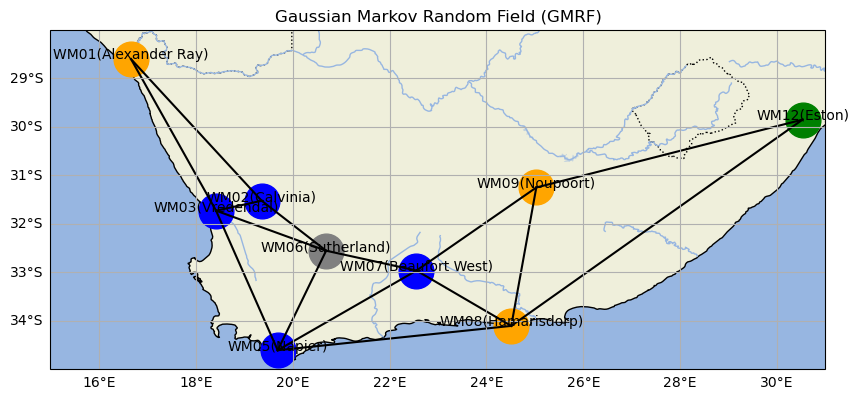

In [13]:
# Create a figure with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural earth features for better map visualization
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the geological map
geo_map.plot(ax=ax, color='white', edgecolor='black')

# Define colors for each region
node_colors = {
    'WM01(Alexander Ray)': 'orange',
    'WM02(Calvinia)': 'blue',
    'WM03(Vredendal)': 'blue',
    'WM05(Napier)': 'blue',
    'WM06(Sutherland)': 'grey',  # WM06 is left as grey
    'WM07(Beaufort West)': 'blue',
    'WM08(Hamarisdorp)': 'orange',
    'WM09(Noupoort)': 'orange',
    'WM12(Eston)': 'green'
}

# Add nodes with positions
for node, (lon, lat) in pos.items():
    ax.plot(lon, lat, 'o', markersize=25, transform=ccrs.PlateCarree(), color=node_colors[node])
    ax.text(lon, lat, node, transform=ccrs.PlateCarree(), fontsize=10, ha='center', color='black')

# Add edges
for (region1, region2) in edges:
    lon1, lat1 = pos[region1]
    lon2, lat2 = pos[region2]
    ax.plot([lon1, lon2], [lat1, lat2], 'b-', transform=ccrs.PlateCarree(), color='black')

# Set the extent of the map
ax.set_extent([15, 31, -35, -28])

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.title("Gaussian Markov Random Field (GMRF)")
plt.show()


## Redefining the GMRF BL to adapt to the prediction of the spatial dependecies neigbours 

In [14]:
# Define a custom estimator class for the GMRF model
class GMRFModelBL(BaseEstimator, RegressorMixin):
    def __init__(self, diag_value=2, nu_prior=None):
        self.diag_value = diag_value
        self.nu_prior = nu_prior

        # Define the edges and node to index mapping
        self.edges = [
            ('WM01', 'WM02'), ('WM01', 'WM03'), ('WM02', 'WM03'),
            ('WM02', 'WM06'), ('WM03', 'WM06'), ('WM03', 'WM05'),
            ('WM05', 'WM06'), ('WM05', 'WM07'), ('WM07', 'WM06'),
            ('WM07', 'WM08'), ('WM08', 'WM09'), ('WM08', 'WM12'),
            ('WM09', 'WM12'), ('WM07', 'WM09'), ('WM08', 'WM05')
        ]
        self.node_to_index = {'WM01': 0, 'WM02': 1, 'WM03': 2, 'WM05': 3, 
                              'WM06': 4, 'WM07': 5, 'WM08': 6, 'WM09': 7, 'WM12': 8}

    def fit(self, X_train, y=None):
        self.n_features = X_train.shape[1]

        # Set default nu_prior if not provided
        if self.nu_prior is None:
            self.nu_prior = self.n_features

        # Compute the empirical mean vector and covariance matrix using the training set
        self.mu_empirical_train = np.mean(X_train, axis=0)
        Sigma_empirical_train = np.cov(X_train, rowvar=False)

        # Define prior and sample posterior precision matrix using the training set
        self.Lambda = np.zeros((self.n_features, self.n_features))
        np.fill_diagonal(self.Lambda, self.diag_value)

        # Update Lambda based on the defined edges
        for (node1, node2) in self.edges:
            idx1 = self.node_to_index[node1]
            idx2 = self.node_to_index[node2]
            self.Lambda[idx1, idx2] = -1
            self.Lambda[idx2, idx1] = -1

        Psi_prior = np.eye(self.n_features)
        nu_posterior = self.nu_prior + X_train.shape[0]
        Psi_posterior = Psi_prior + np.dot(X_train.T, X_train)

        # Sample the posterior precision matrix from the Wishart distribution
        self.Lambda_posterior = wishart.rvs(df=nu_posterior, scale=np.linalg.inv(Psi_posterior))

        # Define Lambda_posterior_chain1 based on the posterior
        self.Lambda_posterior_chain1 = np.zeros_like(self.Lambda_posterior)
        np.fill_diagonal(self.Lambda_posterior_chain1, np.diag(self.Lambda_posterior))
        for (node1, node2) in self.edges:
            idx1 = self.node_to_index[node1]
            idx2 = self.node_to_index[node2]
            self.Lambda_posterior_chain1[idx1, idx2] = self.Lambda_posterior[idx1, idx2]
            self.Lambda_posterior_chain1[idx2, idx1] = self.Lambda_posterior[idx2, idx1]

        return self

    def predict(self, X_test, observed_indices_test):
        unobserved_indices_test = [i for i in range(self.n_features) if i not in observed_indices_test]

        def infer_unobserved_test(precision_matrix, mu, observed_indices, observed_values, unobserved_indices):
            Lambda_oo = precision_matrix[np.ix_(observed_indices, observed_indices)]
            Lambda_ou = precision_matrix[np.ix_(observed_indices, unobserved_indices)]
            Lambda_uu = precision_matrix[np.ix_(unobserved_indices, unobserved_indices)]

            mu_u_given_o = mu[unobserved_indices] - np.dot(np.linalg.inv(Lambda_uu), np.dot(Lambda_ou.T, (observed_values - mu[observed_indices])))

            return mu_u_given_o

        predicted_values_test_all = []
        for test_sample in X_test:
            observed_values_test = test_sample[observed_indices_test]
            predicted_values_test = infer_unobserved_test(self.Lambda_posterior_chain1, self.mu_empirical_train, observed_indices_test, observed_values_test, unobserved_indices_test)
            predicted_values_test_all.append(predicted_values_test)

        return np.array(predicted_values_test_all)

## Ploting the GMRF learning curve for each step neigbours with error bars for 3 locations

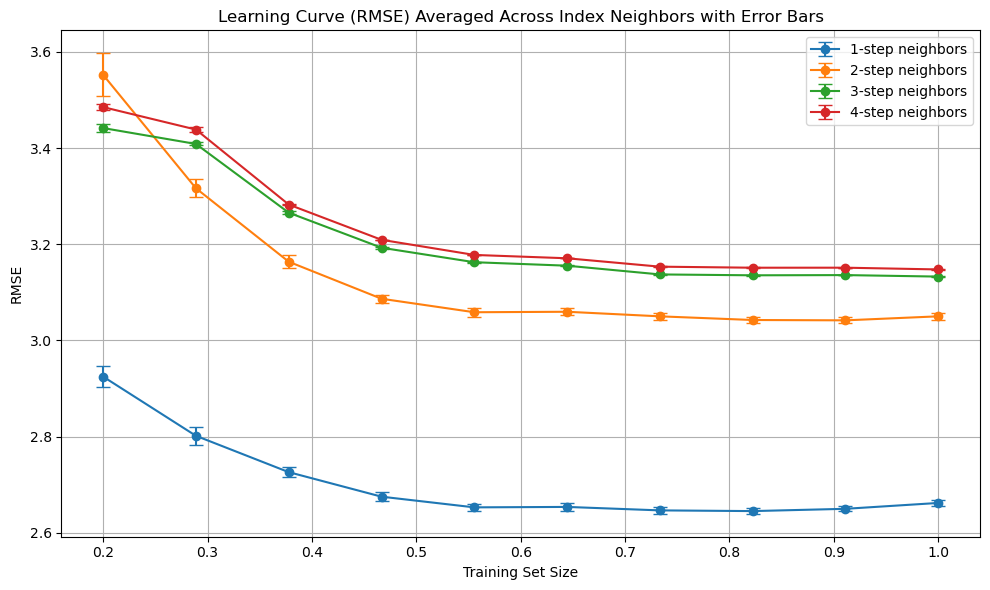

In [15]:
# Define the cross-validation procedure
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the GMRF model with chosen parameters
gmrf_model = GMRFModelBL()

observed_indices_sets1 = [[3, 5, 1, 2],[0, 6, 7],[8], []]
observed_indices_sets2 = [[0, 2, 4],[3, 5],[6, 7],[8]]
observed_indices_sets3 = [[2, 4, 5, 6],[0, 1, 7, 8], [], []]
# Define unobserved index of interest for each location
unobserved_indices_of_interest = {
    'observed_indices_sets1': 4,
    'observed_indices_sets2': 1,
    'observed_indices_sets3': 3
}
# Function to plot learning curves (RMSE) with error bars
def plot_learning_curves_with_error_bars(train_sizes, mean_rmse_scores, std_rmse_scores, labels):
    plt.figure(figsize=(10, 6))

    # Plot RMSE learning curve with error bars for each neighbor set
    for i, (mean_rmse, std_rmse) in enumerate(zip(mean_rmse_scores, std_rmse_scores)):
        if i < len(labels):
            plt.errorbar(train_sizes, mean_rmse, yerr=std_rmse, fmt='-o', capsize=5, label=labels[i])

    plt.title('Learning Curve (RMSE) Averaged Across Index Neighbors with Error Bars')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('combined_learning_curve_neighbours_with_error_bars.png')
    plt.show()

# Function to compute RMSE for a given set of observed indices and a given unobserved index
def compute_rmse_with_repeats(observed_indices_set, unobserved_index_of_interest, train_sizes, kf, X, model, repeats=10):
    rmse_scores_set = []

    for train_size in train_sizes:
        rmse_scores_repeat = []

        # Repeat experiment `repeats` times
        for _ in range(repeats):
            rmse_scores_fold = []

            # Perform cross-validation with varying training set sizes
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                
                # Subset the training data according to the current train_size
                n_train_samples = int(train_size * X_train.shape[0])
                X_train_subset = X_train[:n_train_samples]
                
                # Fit the model on the subset of training data
                model.fit(X_train_subset)
                predicted_values_test_all = model.predict(X_test, observed_indices_set)

                # Find the position of unobserved_index_of_interest in the unobserved indices
                unobserved_indices_test = [i for i in range(model.n_features) if i not in observed_indices_set]
                if unobserved_index_of_interest not in unobserved_indices_test:
                    continue  # Skip if the unobserved index is not in the test set
                index_position = unobserved_indices_test.index(unobserved_index_of_interest)

                # Extract the relevant predicted values
                predicted_values_test = predicted_values_test_all[:, index_position]

                # Actual values for the unobserved index
                actual_values_test = X_test[:, unobserved_index_of_interest]

                # Calculate the RMSE
                rmse = np.sqrt(mean_squared_error(actual_values_test, predicted_values_test))
                rmse_scores_fold.append(rmse)

            # Store the average RMSE across folds for this repeat
            rmse_scores_repeat.append(np.mean(rmse_scores_fold))

        # Append the mean and std deviation for RMSE across repeats
        rmse_scores_set.append((np.mean(rmse_scores_repeat), np.std(rmse_scores_repeat)))

    return rmse_scores_set

# Define the different training set sizes (as fractions of the full training set)
train_sizes = np.linspace(0.2, 1.0, 10)

# Initialize lists to store the RMSE scores for each label
mean_rmse_scores_all = []
std_rmse_scores_all = []
dynamic_labels = []  # Dynamic list for available labels

# Create a KFold instance
kf = KFold(n_splits=5)

# Collect and average RMSE across 1st, 2nd, 3rd neighbor, etc.
for ith_index in range(4):  # Assume we are working with a max of 4 neighbors
    mean_rmse_scores_for_ith_index = []
    std_rmse_scores_for_ith_index = []

    # Loop through each set (set1, set2, set3)
    for observed_indices_sets, set_name in zip([observed_indices_sets1, observed_indices_sets2, observed_indices_sets3],
                                               ['observed_indices_sets1', 'observed_indices_sets2', 'observed_indices_sets3']):
        
        # Check if the current set has enough neighbors for ith index
        if ith_index < len(observed_indices_sets):
            unobserved_index_of_interest = unobserved_indices_of_interest[set_name]
            observed_indices_set = observed_indices_sets[ith_index]
            
            # Compute RMSE for the ith index in this set with repeats for error bars
            rmse_scores_with_errors = compute_rmse_with_repeats(observed_indices_set, unobserved_index_of_interest, train_sizes, kf, X, gmrf_model, repeats=10)
            
            # Separate mean and std deviation for each training size
            means, stds = zip(*rmse_scores_with_errors)
            mean_rmse_scores_for_ith_index.append(means)
            std_rmse_scores_for_ith_index.append(stds)

    # If we have RMSE values for this ith index, average them
    if mean_rmse_scores_for_ith_index:
        avg_mean_rmse_scores = np.mean(mean_rmse_scores_for_ith_index, axis=0)
        avg_std_rmse_scores = np.mean(std_rmse_scores_for_ith_index, axis=0)
        mean_rmse_scores_all.append(avg_mean_rmse_scores)
        std_rmse_scores_all.append(avg_std_rmse_scores)
        dynamic_labels.append(f'{ith_index + 1}-step neighbors')  # Adjust label for neighbor index

# Plot the RMSE learning curves with dynamic labels for neighbors and error bars
plot_learning_curves_with_error_bars(train_sizes, mean_rmse_scores_all, std_rmse_scores_all, dynamic_labels)

# Ploting GMRF showing the distance bands 

C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: Us

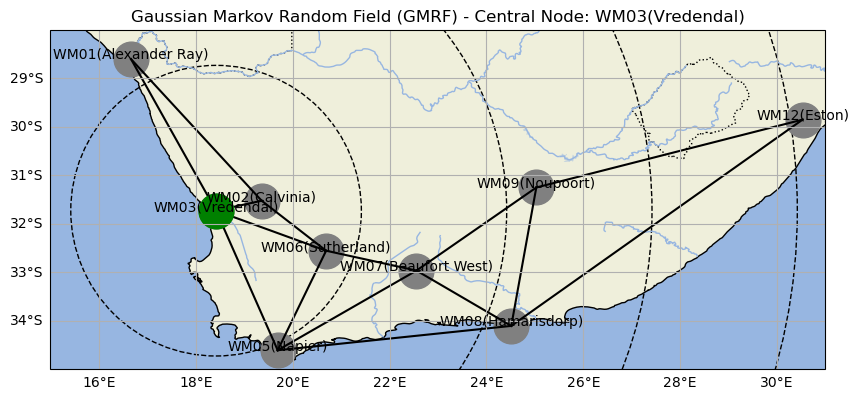

C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: Us

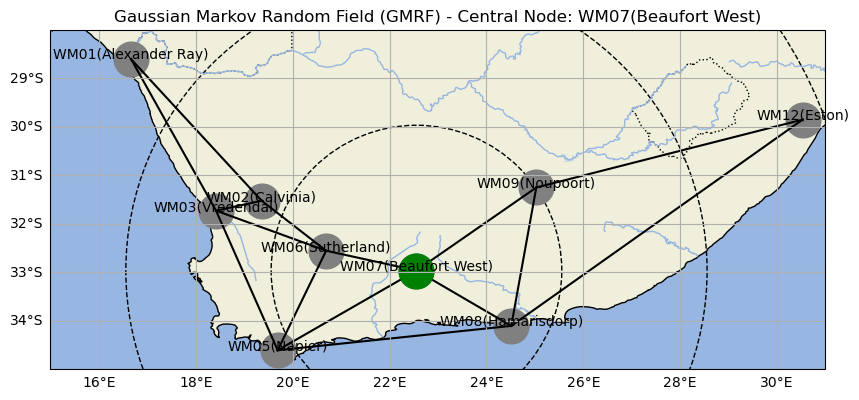

C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
C:\Users\mpeph\AppData\Local\Temp\ipykernel_30804\2611636044.py:87: Us

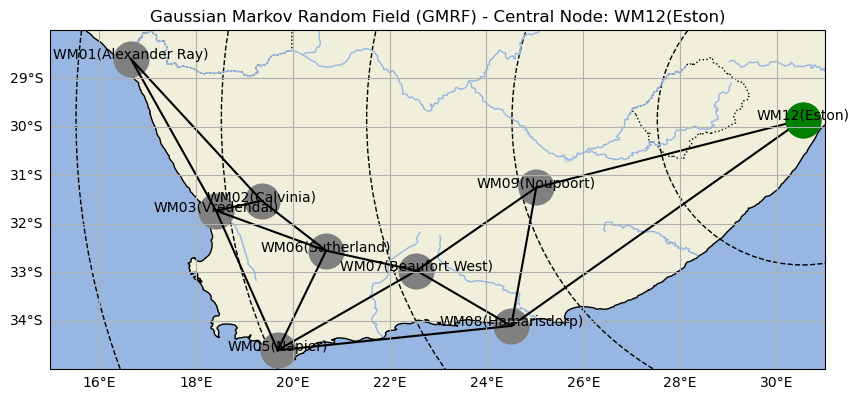

In [16]:
# Load the synthetic geological map
geo_map = gpd.read_file('synthetic_geological_map.shp')

# Define the DMS to Decimal Degrees conversion function
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

wm01_lat = dms_to_dd(28, 36, 6.7, 'S')
wm01_lon = dms_to_dd(16, 39, 51.9, 'E')

wm02_lat = dms_to_dd(31, 31, 29.7, 'S')
wm02_lon = dms_to_dd(19, 21, 38.7, 'E')

wm03_lat = dms_to_dd(31, 43, 49.4, 'S')
wm03_lon = dms_to_dd(18, 25, 10.1, 'E')

wm05_lat = dms_to_dd(34, 36, 41.6, 'S')
wm05_lon = dms_to_dd(19, 41, 30.3, 'E')

wm06_lat = dms_to_dd(32, 33, 24.4, 'S')
wm06_lon = dms_to_dd(20, 41, 28.7, 'E')

wm07_lat = dms_to_dd(32, 58, 0.2, 'S')
wm07_lon = dms_to_dd(22, 33, 23.8, 'E')

wm08_lat = dms_to_dd(34, 6, 32.0, 'S')
wm08_lon = dms_to_dd(24, 30, 49.0, 'E')

wm09_lat = dms_to_dd(31, 15, 5.8, 'S')
wm09_lon = dms_to_dd(25, 1, 50.2, 'E')

wm12_lat = dms_to_dd(29, 51, 0.4, 'S')
wm12_lon = dms_to_dd(30, 31, 42.8, 'E')

# Update positions dictionary with decimal degrees
pos = {
    'WM01(Alexander Ray)': (wm01_lon, wm01_lat),
    'WM02(Calvinia)': (wm02_lon, wm02_lat),
    'WM03(Vredendal)': (wm03_lon, wm03_lat),
    'WM05(Napier)': (wm05_lon, wm05_lat),
    'WM06(Sutherland)': (wm06_lon, wm06_lat),
    'WM07(Beaufort West)': (wm07_lon, wm07_lat),
    'WM08(Hamarisdorp)': (wm08_lon, wm08_lat),
    'WM09(Noupoort)': (wm09_lon, wm09_lat),
    'WM12(Eston)': (wm12_lon, wm12_lat)
}

# Create a Gaussian Markov network
G = nx.Graph()
regions = list(pos.keys())
edges = [
    ('WM01(Alexander Ray)', 'WM02(Calvinia)'), ('WM01(Alexander Ray)', 'WM03(Vredendal)'), ('WM02(Calvinia)', 'WM03(Vredendal)'),
    ('WM02(Calvinia)', 'WM06(Sutherland)'), ('WM03(Vredendal)', 'WM06(Sutherland)'), ('WM03(Vredendal)', 'WM05(Napier)'),
    ('WM05(Napier)', 'WM06(Sutherland)'), ('WM05(Napier)', 'WM07(Beaufort West)'), ('WM07(Beaufort West)', 'WM06(Sutherland)'),
    ('WM07(Beaufort West)', 'WM08(Hamarisdorp)'), ('WM08(Hamarisdorp)', 'WM09(Noupoort)'), ('WM08(Hamarisdorp)', 'WM12(Eston)'),
    ('WM09(Noupoort)', 'WM12(Eston)'), ('WM07(Beaufort West)', 'WM09(Noupoort)'), ('WM08(Hamarisdorp)', 'WM05(Napier)')
]
G.add_nodes_from(regions)
G.add_edges_from(edges)

# Define the specific nodes to plot
central_nodes = ['WM03(Vredendal)', 'WM07(Beaufort West)', 'WM12(Eston)']

# Iterate through the selected central nodes to create separate plots
for central_node in central_nodes:
    # Create a new figure for each central node
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add natural earth features for better map visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Plot the geological map
    geo_map.plot(ax=ax, color='white', edgecolor='black')

    # Add nodes with positions
    for node, (lon, lat) in pos.items():
        ax.plot(lon, lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='grey')
        ax.text(lon, lat, node, transform=ccrs.PlateCarree(), fontsize=10, ha='center', color='black')

    # Add edges
    for (region1, region2) in edges:
        lon1, lat1 = pos[region1]
        lon2, lat2 = pos[region2]
        ax.plot([lon1, lon2], [lat1, lat2], 'b-', transform=ccrs.PlateCarree(), color='black')

    # Highlight the central node
    central_lon, central_lat = pos[central_node]
    ax.plot(central_lon, central_lat, 'ro', markersize=25, transform=ccrs.PlateCarree(), color='green')

    # Draw distance bands around the central node
    for radius in [3, 6, 9, 12, 15]:  # Example radii in degrees (adjust as needed)
        circle = Circle((central_lon, central_lat), radius, transform=ccrs.PlateCarree(),
                        edgecolor='black', facecolor='none', linestyle='--', linewidth=1)
        ax.add_patch(circle)

    # Set the extent of the map
    ax.set_extent([15, 31, -35, -28])

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    plt.title(f"Gaussian Markov Random Field (GMRF) - Central Node: {central_node}")
    plt.show()


## Ploting the learning curve for each distance band with error bars 

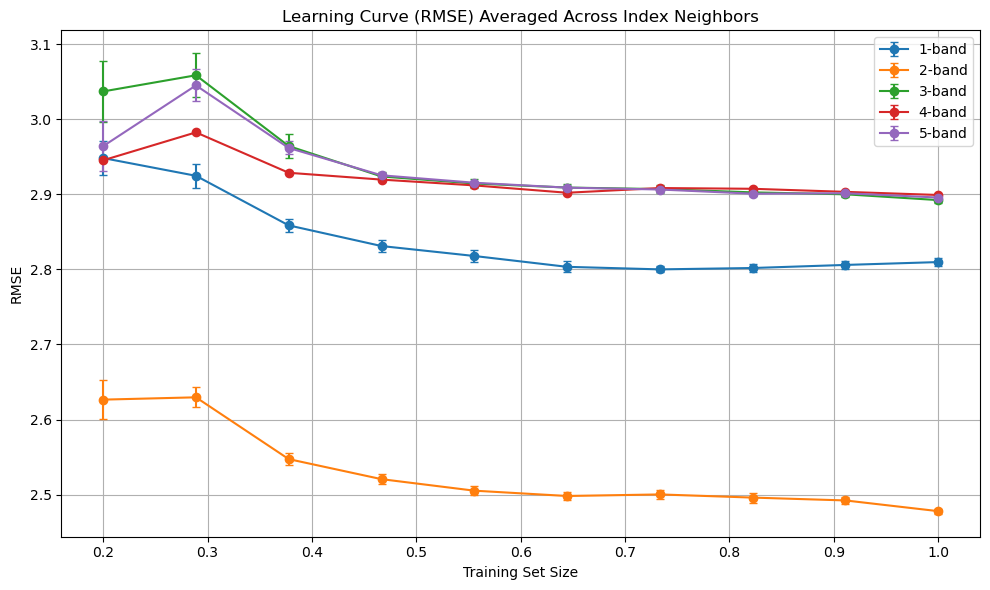

In [17]:
# Define observed indices sets
observed_indices_sets1 = [[1, 4, 3], [0, 5], [6, 7], [], [8]]
observed_indices_sets2 = [[4, 6, 7], [1, 2, 3], [0, 8], [], []]
observed_indices_sets3 = [[], [7], [6, 5], [2, 3, 4], [0, 1]]

# Define unobserved index of interest for each observed set
unobserved_indices_of_interest = {
    'observed_indices_sets1': 2,
    'observed_indices_sets2': 5,
    'observed_indices_sets3': 8
}

# Function to plot learning curves with error bars for RMSE
def plot_learning_curves(train_sizes, rmse_means, rmse_stds, labels):
    plt.figure(figsize=(10, 6))

    # Plot RMSE learning curve with error bars and labels
    for i, (rmse_mean, rmse_std) in enumerate(zip(rmse_means, rmse_stds)):
        if i < len(labels):
            plt.errorbar(train_sizes, rmse_mean, fmt='-o', yerr=rmse_std, label=labels[i], capsize=3)

    plt.title('Learning Curve (RMSE) Averaged Across Index Neighbors')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.savefig('combined_learning_curve_distance_with_error_bars.png')
    plt.tight_layout()
    plt.show()

# Function to compute RMSE for a given set of observed indices and a given unobserved index, with repetitions
def compute_rmse_with_repeats(observed_indices_set, unobserved_index_of_interest, train_sizes, kf, X, model, repeats=10):
    rmse_means = []
    rmse_stds = []
    
    for train_size in train_sizes:
        rmse_repeats = []

        # Repeat the experiment 'repeats' times
        for _ in range(repeats):
            rmse_scores_fold = []

            # Cross-validation with varying training set sizes
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]

                # Subset the training data according to the current train_size
                n_train_samples = int(train_size * X_train.shape[0])
                X_train_subset = X_train[:n_train_samples]

                # Fit the model on the subset of training data
                model.fit(X_train_subset)
                predicted_values_test_all = model.predict(X_test, observed_indices_set)

                # Find the position of unobserved_index_of_interest in the unobserved indices
                unobserved_indices_test = [i for i in range(model.n_features) if i not in observed_indices_set]
                if unobserved_index_of_interest not in unobserved_indices_test:
                    continue  # Skip if the unobserved index is not in the test set
                index_position = unobserved_indices_test.index(unobserved_index_of_interest)

                # Extract the relevant predicted values
                predicted_values_test = predicted_values_test_all[:, index_position]

                # Actual values for the unobserved index
                actual_values_test = X_test[:, unobserved_index_of_interest]

                # Calculate the RMSE
                rmse = np.sqrt(mean_squared_error(actual_values_test, predicted_values_test))
                rmse_scores_fold.append(rmse)

            # Average RMSE for this train size across folds
            rmse_repeats.append(np.mean(rmse_scores_fold))

        # Compute the mean and standard deviation of RMSE across repeats
        rmse_means.append(np.mean(rmse_repeats))
        rmse_stds.append(np.std(rmse_repeats))

    return rmse_means, rmse_stds

# Define the different training set sizes (as fractions of the full training set)
train_sizes = np.linspace(0.2, 1.0, 10)

# Initialize lists to store the RMSE means and standard deviations for each label
rmse_means_all = []
rmse_stds_all = []
dynamic_labels = []  # Dynamic list for available labels

# Create a KFold instance
kf = KFold(n_splits=5)

# Collect and average RMSE across 1st, 2nd, 3rd neighbor, etc.
for ith_index in range(5):  # Assume we are working with a max of 4 neighbors
    rmse_means_for_ith_index = []
    rmse_stds_for_ith_index = []

    # Loop through each set (set1, set2, set3)
    for observed_indices_sets, set_name in zip(
        [observed_indices_sets1, observed_indices_sets2, observed_indices_sets3],
        ['observed_indices_sets1', 'observed_indices_sets2', 'observed_indices_sets3']):
        
        # Check if the current set has enough neighbors for ith index
        if ith_index < len(observed_indices_sets):
            unobserved_index_of_interest = unobserved_indices_of_interest[set_name]
            observed_indices_set = observed_indices_sets[ith_index]
            
            # Compute RMSE means and stds for the ith index in this set
            rmse_means, rmse_stds = compute_rmse_with_repeats(
                observed_indices_set, unobserved_index_of_interest, train_sizes, kf, X, gmrf_model, repeats=10)
            
            rmse_means_for_ith_index.append(rmse_means)
            rmse_stds_for_ith_index.append(rmse_stds)
    
    # If we have RMSE values for this ith index, average them
    if rmse_means_for_ith_index:
        avg_rmse_means = np.mean(rmse_means_for_ith_index, axis=0)
        avg_rmse_stds = np.mean(rmse_stds_for_ith_index, axis=0)
        rmse_means_all.append(avg_rmse_means)
        rmse_stds_all.append(avg_rmse_stds)
        dynamic_labels.append(f'{ith_index + 1}-band')  # Adjust label for neighbor index

# Plot the RMSE learning curves with dynamic labels for neighbors
plot_learning_curves(train_sizes, rmse_means_all, rmse_stds_all, dynamic_labels)
